In [1]:
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt

**The shared data contains only prepared data: `X_train`, `y_train`, `X_valid`, `y_valid`. To reproduce, execute the commented code below (first, uncomment it of course) and move to RF training (cell 13 or 14).**

In [4]:
# # how to read data
import pickle
with open('/Users/rakhmangulovs/Downloads/mobile_app_launches_sessions_payments.pkl', 'rb') as f:
     shared_data = pickle.load(f)
X_train, y_train = shared_data['X_train'], shared_data['y_train']
X_valid, y_valid = shared_data['X_valid'], shared_data['y_valid']

In [ ]:
df = pd.read_csv('../../data/mobile_app_launches_sessions_payments.csv.gz')

In [ ]:
df.shape

(1177829, 49)

In [ ]:
df.columns

Index(['idfa', 'idfv', 'gaid', 'android_id', 'imei', 'waid', 'idDevice',
       'idProfile', 'idApp', 'idCountry', 'idRegion', 'age', 'idGender', 'dt',
       'launches1', 'launches2', 'launches3', 'launches4', 'launches5',
       'launches6', 'launches7', 'launches8', 'sessions1', 'sessions2',
       'sessions3', 'sessions4', 'sessions5', 'sessions6', 'sessions7',
       'sessions8', 'num_payments1', 'num_payments2', 'num_payments3',
       'num_payments4', 'num_payments5', 'num_payments6', 'num_payments7',
       'num_payments8', 'sum_payments1', 'sum_payments2', 'sum_payments3',
       'sum_payments4', 'sum_payments5', 'sum_payments6', 'sum_payments7',
       'sum_payments8', 'ltvDay30', 'ltvDay60', 'ltvDay90'],
      dtype='object')

In [ ]:
(df['sum_payments8'] > 0).value_counts()

False    1108205
True       69624
Name: sum_payments8, dtype: int64

In [ ]:
df.sort_values(by='dt', inplace=True)

In [ ]:
y = (df['ltvDay90'] > 0).astype('int')

In [ ]:
y.mean()

0.07425356312333964

In [90]:
sessions = ['sessions' + str(i) for i in range(1, 9)]
launches = ['launches' + str(i) for i in range(1, 9)]
num_payments = ['num_payments' + str(i) for i in range(1, 9)]
sum_payments = ['sum_payments' + str(i) for i in range(1, 9)]

In [92]:
X = X_valid[sessions + launches + num_payments + sum_payments]

In [ ]:
X.shape, y.shape

In [ ]:
train_share = 0.7
train_size = int(train_share * X.shape[0])

X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

In [7]:
y_train.mean(), y_valid.mean()

(0.0763147680962546, 0.06944409068654503)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [12]:
forest = RandomForestClassifier(n_estimators=300, class_weight='balanced',
                                n_jobs=4, random_state=17)

In [13]:
%%time
forest.fit(X_train, y_train)

CPU times: user 3min 44s, sys: 2.82 s, total: 3min 47s
Wall time: 58.4 s


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=4,
                       random_state=17)

In [14]:
forest_pred_probs = forest.predict_proba(X_valid)[:, 1]

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

**Is that good?**

In [19]:
roc_auc_score(y_valid, forest_pred_probs)

0.9650000908647615

**Accuracy can be misleading**

*Baseline*

In [20]:
accuracy_score(y_valid, X_valid['sum_payments8'] > 0)

0.9879156301560214

In [21]:
accuracy_score(y_valid, forest_pred_probs > 0.5)

0.9857393115588271

In [22]:
y_valid.shape

(353349,)

In [23]:
pred_df = pd.DataFrame({'true': y_valid, 'pred_forest': forest_pred_probs, 
             'pred_baseline': (X_valid['sum_payments8'] > 0).astype('int')})

In [28]:
pred_df.sort_values(by='pred_forest', ascending=False, inplace=True)
pred_df.head()

,true,pred_forest,pred_baseline
36040,1,1.0,1
72208,1,1.0,1
12651,1,1.0,1
7614,1,1.0,1
50192,1,1.0,1


In [32]:
pred_df.iloc[:50000]['true'].mean() / y_valid.mean()

6.295424069606325

In [33]:
pred_df.sort_values(by='pred_baseline', 
                    ascending=False).iloc[:50000]['true'].mean() / y_valid.mean()

5.871485910017117

**Precision/recall**

In [34]:
precision_score(y_valid, forest_pred_probs > 0.5), \
    precision_score(y_valid, X_valid['sum_payments8'] > 0),

(0.9614711033274956, 1.0)

In [35]:
recall_score(y_valid, forest_pred_probs > 0.5), \
    recall_score(y_valid, X_valid['sum_payments8'] > 0),

(0.8278180780829734, 0.825984187790366)

In [36]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_valid, forest_pred_probs > 0.5), \
    f1_score(y_valid, X_valid['sum_payments8'] > 0),

(0.8896237571722657, 0.904700263357586)

In [41]:
pip install funcsigs

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


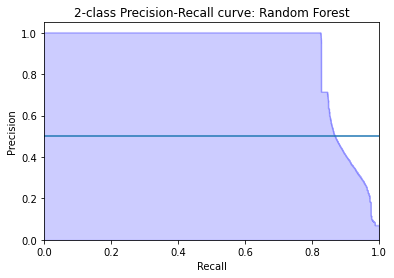

In [42]:
from sklearn.metrics import precision_recall_curve
# from sklearn.utils.fixes import signature
from funcsigs import signature

precision, recall, thres = precision_recall_curve(y_valid, forest_pred_probs)
    
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.hlines(y=0.5, xmin=0, xmax=1)
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Random Forest');

In [37]:
tau = 0
precision_score(y_valid, forest_pred_probs > tau), \
recall_score(y_valid, forest_pred_probs > tau)

(0.08411308949912949, 0.9883853614801532)

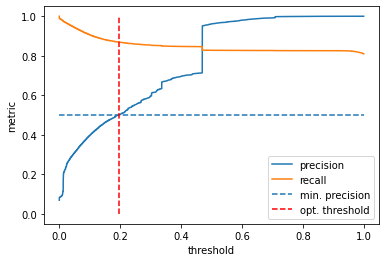

In [49]:
plt.plot(thres, precision[:-1], label='precision')
plt.plot(thres, recall[:-1], label='recall');
plt.hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
plt.vlines(x=0.195, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')
plt.legend();
plt.xlabel('threshold')
plt.ylabel('metric');

In [44]:
precision_score(y_valid, forest_pred_probs > 0.194), \
    recall_score(y_valid, forest_pred_probs > 0.194)

(0.5012687373713641, 0.8694677642839678)

In [50]:
precision_score(y_valid, X_valid['sum_payments8'] > 0),\
recall_score(y_valid, X_valid['sum_payments8'] > 0),

(1.0, 0.825984187790366)

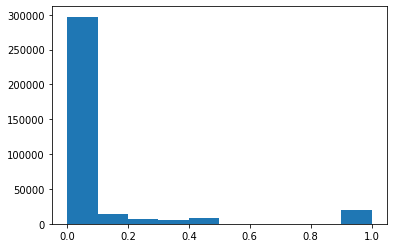

In [85]:
plt.hist(forest_pred_probs);

**Feature importance**

In [89]:
forest.feature_importances_

array([0.01306427, 0.01408645, 0.01459825, 0.01548729, 0.0168702 ,
       0.02156968, 0.02625049, 0.0403809 , 0.01331575, 0.01574201,
       0.01545822, 0.01710981, 0.01847801, 0.02195262, 0.02920485,
       0.03982181, 0.00478364, 0.01171862, 0.0208067 , 0.02600191,
       0.03398163, 0.06304696, 0.07484035, 0.12015903, 0.00288291,
       0.00729568, 0.0120586 , 0.02018938, 0.03630402, 0.04323586,
       0.07241362, 0.11689051])

In [93]:
pd.DataFrame(forest.feature_importances_, index=X.columns,
             columns=['importance']).sort_values(by='importance',
                                                ascending=False)

,importance
num_payments8,0.120159
sum_payments8,0.116891
num_payments7,0.074840
sum_payments7,0.072414
num_payments6,0.063047
sum_payments6,0.043236
sessions8,0.040381
launches8,0.039822
sum_payments5,0.036304
num_payments5,0.033982


In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

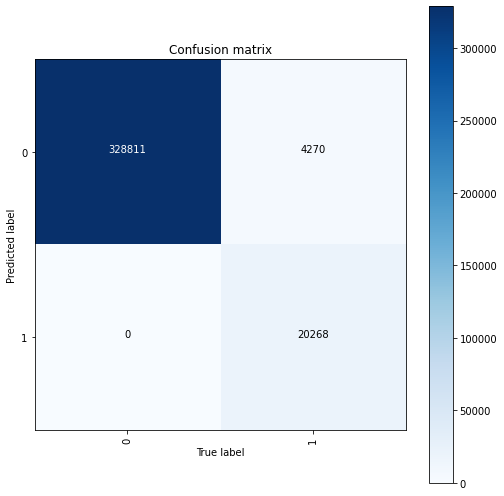

In [54]:
plot_confusion_matrix(actual=y_valid, predicted=X_valid['sum_payments8'] > 0,
                     classes=forest.classes_)

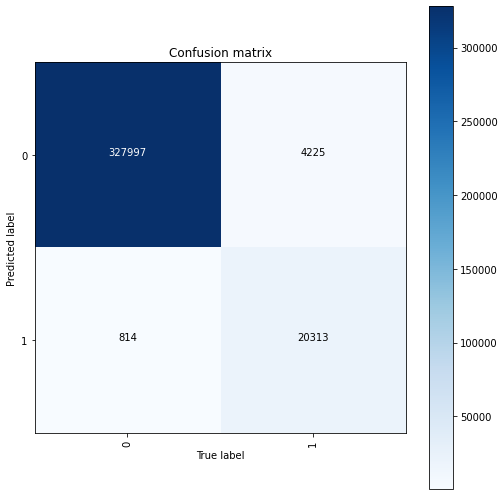

In [55]:
plot_confusion_matrix(actual=y_valid, predicted=(forest_pred_probs > 0.5),
                     classes=forest.classes_)

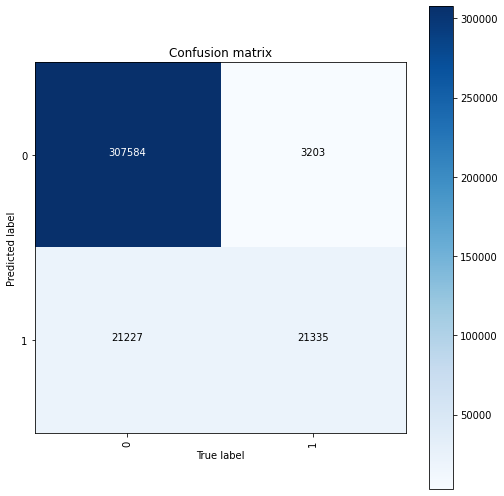

In [56]:
plot_confusion_matrix(actual=y_valid, predicted=(forest_pred_probs > 0.194),
                     classes=forest.classes_)

## Logistic regression

In [59]:
from sklearn.preprocessing import StandardScaler

In [64]:
logit = LogisticRegression(n_jobs=-1, random_state=17, 
                           class_weight='balanced', solver='sag')

In [61]:
scaler = StandardScaler()

In [62]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [65]:
%%time
logit.fit(X_train_scaled, y_train)

CPU times: user 31.9 s, sys: 158 ms, total: 32 s
Wall time: 32.1 s


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=17,
                   solver='sag')

In [66]:
logit_pred_probs = logit.predict_proba(X_valid_scaled)[:, 1]

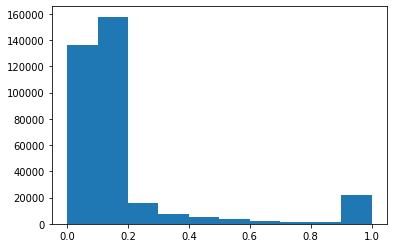

In [67]:
plt.hist(logit_pred_probs);

**Is that good?**

In [68]:
roc_auc_score(y_valid, logit_pred_probs)

0.9764940094392004

**Accuracy can be misleading**

*Baseline*

In [69]:
accuracy_score(y_valid, X_valid['sum_payments8'] > 0)

0.9879156301560214

In [71]:
accuracy_score(y_valid, logit_pred_probs > 0.5)

0.9642449815904389

In [72]:
pred_df = pd.DataFrame({'true': y_valid, 'pred_logit': logit_pred_probs, 
             'pred_baseline': (X_valid['sum_payments8'] > 0).astype('int')})

In [73]:
pred_df.sort_values(by='pred_logit', ascending=False, inplace=True)
pred_df.head()

,true,pred_logit,pred_baseline
62466,1,1.0,1
10587,1,1.0,1
32466,1,1.0,1
52663,1,1.0,1
52996,1,1.0,1


In [74]:
pred_df.iloc[:50000]['true'].mean() / y_valid.mean()

6.4604489102616345

In [75]:
pred_df.sort_values(by='pred_baseline', 
                    ascending=False).iloc[:50000]['true'].mean() / y_valid.mean()

5.840669753036107

**Precision/recall**

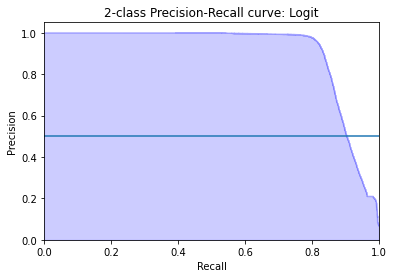

In [76]:
precision, recall, thres = precision_recall_curve(y_valid, logit_pred_probs)
    
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.hlines(y=0.5, xmin=0, xmax=1)
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Logit');

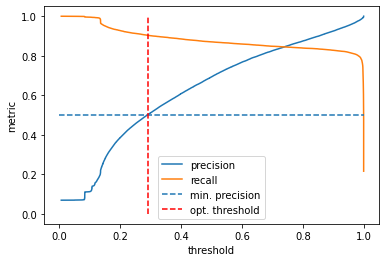

In [77]:
plt.plot(thres, precision[:-1], label='precision')
plt.plot(thres, recall[:-1], label='recall');
plt.hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
plt.vlines(x=0.29, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')
plt.legend();
plt.xlabel('threshold')
plt.ylabel('metric');

In [78]:
precision_score(y_valid, logit_pred_probs > 0.29), \
    recall_score(y_valid, logit_pred_probs > 0.29)

(0.5012316662523447, 0.9038633955497596)

In [82]:
precision_score(y_valid, X_valid['sum_payments8'] > 0),\
recall_score(y_valid, X_valid['sum_payments8'] > 0),

(1.0, 0.825984187790366)

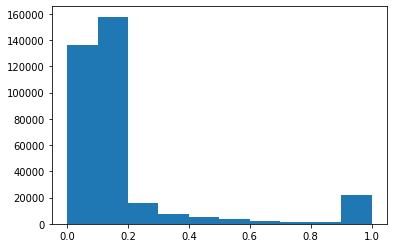

In [80]:
plt.hist(logit_pred_probs);

**Logistic regression worked better for us. Cool! We'll stick to this model. Also, logit will work better in case of sparse features.**

**Now let's take a look at coefficients**

In [94]:
pd.DataFrame(logit.coef_.reshape(-1, 1), index=X.columns,
             columns=['coef']).sort_values(by='coef',
                                                ascending=False)

,coef
num_payments8,3.415361
num_payments7,2.247397
num_payments6,1.757264
sessions8,1.605800
num_payments5,1.471147
sessions1,1.445354
num_payments4,1.290498
num_payments3,1.121328
num_payments2,0.975069
sessions2,0.951102


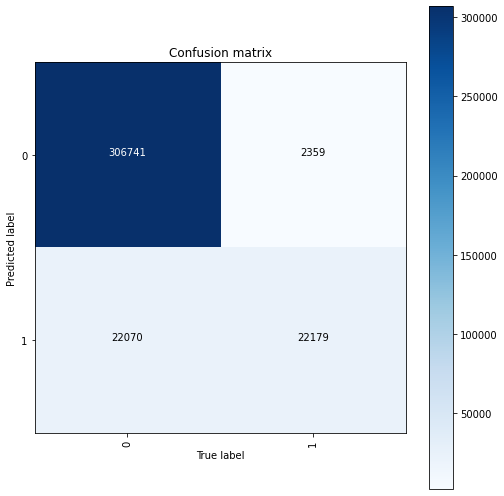

In [95]:
plot_confusion_matrix(actual=y_valid, predicted=(logit_pred_probs > 0.29),
                     classes=logit.classes_)

In [ ]:
# import pickle

In [ ]:
# data_to_share = {'X_train': X_train,
#                  'y_train': y_train,
#                  'X_valid': X_valid,
#                  'y_valid': y_valid}

In [ ]:
# with open('../../data/mobile_app_launches_sessions_payments.pkl', 'wb') as f:
#     pickle.dump(data_to_share, f)